In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (8.25, 6)

<h3>NOTES</h3>
<ul>
    <li>We may be able to extrapolate latitude and longitude to fill in the missing values based on the county they are in</li>
    <li>We may be able to fill in missing gaps for magnitude by manually looking them up</li> 
    <li>We looked for specific county spending on infrastructure but were not able to find anything</li>
    <li>For missing latitudes and longitudes, we looked at the county and derived it from there (we also assumed the ending latitude and longitude would be the same)</li>
</ul>
    
TODO:
<ul>
    <li>Compare with and without estimate property</li>
    <li>Split all in test and training and get accuracies and errors</li>
    <li>Make heatmap plots for wildfires and thunderstorms</li>
    <li>include change in wind direction (azimuth) and begin and end direction</li>
</ul>

<h2>1. Thunderstorms in Texas with no income</h2>

In [48]:
# Get the data
# column 1 = county name
# column 2 = begin location
# column 3 = begin date
# column 4 = begin time
# column 6 = magnitude
# column 10 = property damage
# column 11 = crops damage
# column 29 = end location
# column 30 = begin latitude
# column 31 = begin longitude
# column 32 = end latitude
# colunn 33 = end longitude

# load top 500 thunderstorms in texas from 1950 - 2018
data = pd.read_csv("texas_thunderstorm.csv", usecols=[1, 2, 3, 4, 6, 10, 11, 29, 30, 31, 32, 33])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 12 columns):
CZ_NAME_STR            353 non-null object
BEGIN_LOCATION         353 non-null object
BEGIN_DATE             353 non-null object
BEGIN_TIME             353 non-null int64
MAGNITUDE              353 non-null float64
DAMAGE_PROPERTY_NUM    353 non-null int64
DAMAGE_CROPS_NUM       353 non-null int64
END_LOCATION           353 non-null object
BEGIN_LAT              353 non-null float64
BEGIN_LON              353 non-null float64
END_LAT                353 non-null float64
END_LON                353 non-null float64
dtypes: float64(5), int64(3), object(4)
memory usage: 33.2+ KB


<h3>1.1 Features and outcomes</h3>

In [52]:
# The outcomes
thunderstorm_outcomes = data.iloc[:, [4]]

list(thunderstorm_outcomes)

['MAGNITUDE']

In [53]:
# The predictors
thunderstorm_predictors = data.drop(['DAMAGE_PROPERTY_NUM',
                                     'BEGIN_LOCATION',
                                     'END_LOCATION',
                                     'CZ_NAME_STR',
                                     'BEGIN_DATE'], axis=1)

# NOTE: for right now crops damage is included, but we may want to see both with and without including this

list(thunderstorm_predictors)

['BEGIN_TIME',
 'MAGNITUDE',
 'DAMAGE_CROPS_NUM',
 'BEGIN_LAT',
 'BEGIN_LON',
 'END_LAT',
 'END_LON']

<h3>1.2 Preprocess features and outputs</h3>

In [25]:
# Make the outcomes into a numpy array
outcome_array = thunderstorm_outcomes.values.astype(np.float)
np.random.shuffle(outcome_array)

# split into test and training data
split_index = int(0.8 * len(outcome_array))
outcome_array_train = outcome_array[:split_index, :]
outcome_array_test = outcome_array[split_index:, :]
print(outcome_array_train.shape)
print('Shape of outcome array training', outcome_array_train.shape)
print('Shape of outcome array test', outcome_array_test.shape)

# normalize outcome
outcome_array_train = (outcome_array_train - np.mean(outcome_array))/np.std(outcome_array)
outcome_array_test = (outcome_array_test - np.mean(outcome_array))/np.std(outcome_array)

# Make that numpy array into a torch Tensor
outcome_Tensor_train = torch.from_numpy(outcome_array_train)
outcome_Tensor_test = torch.from_numpy(outcome_array_test)

# Make the predictors into a numpy array
predictors_array = thunderstorm_predictors.values
# NOTE: we took out any missing data values in the csv 

# split into test and training data
predictors_array_train = predictors_array[:split_index, :]
predictors_array_test = predictors_array[split_index:, :]
print('Shape of inputs array training', predictors_array_train.shape)
print('Shape of inputs array test', predictors_array_test.shape)

# Normalize inputs
predictors_array_train = (predictors_array_train - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)
predictors_array_test = (predictors_array_test - np.mean(predictors_array, axis=0))/np.std(predictors_array, axis=0)

# Make that numpy array into a torch Tensor
predictors_Tensor_train = torch.from_numpy(predictors_array_train.astype(np.float))
predictors_Tensor_test = torch.from_numpy(predictors_array_test.astype(np.float))

# Convert those DoubleTensors to FloatTensors
# Chaning outcomes from a DoubleTensor to a FloatTensor
outcome_Tensor_train = outcome_Tensor_train.float()
outcome_Tensor_test = outcome_Tensor_test.float()

# Changing the predictors too
predictors_Tensor_train = predictors_Tensor_train.float()
predictors_Tensor_test = predictors_Tensor_test.float()

(282, 1)
Shape of outcome array training (282, 1)
Shape of outcome array test (71, 1)
Shape of inputs array training (282, 7)
Shape of inputs array test (71, 7)


<h3>1.3 One Hidden Layer NN</h3>

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 5)
        self.fc2 = torch.nn.Linear(5, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)
    
# Make it
one_hidden_model = Net()

In [7]:
# Define the loss function
loss_fn = torch.nn.MSELoss(size_average = False)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


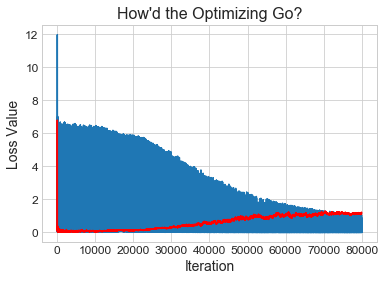

In [35]:
def train_neural_net(model, train_outcomes, train_inputs, test_outcomes, test_inputs):
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_test_loss_value = []
    
    # Set the optimizer
    # originally step size was 1e-2
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-1)
    
    # Train the neural network
    # 100000 iterations seems to give much better results when networks is two layers deep
    for t in range(80000):
        # Get the current mini-batch indices
        indices = torch.randperm(len(train_inputs))[0:50]
        
        # Get the current mini-batches
        predictors_mini = train_inputs[indices]
        outcome_mini = train_outcomes[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        test_pred = model(test_inputs)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data.item())
        
        current_test_loss = loss_fn(test_pred, test_outcomes)
        current_test_loss_value.append(current_test_loss.data.item())
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
        
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 80000))
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_test = (np.asarray(current_test_loss_value) / len(test_inputs)).tolist()
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_test, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)
    
train_neural_net(one_hidden_model, outcome_Tensor_train, predictors_Tensor_train, 
                 outcome_Tensor_test, predictors_Tensor_test)

In [9]:
def plot_train_perf(train_predictors, train_obs, model):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictors.requires_grad = False
    train_predictions = model(train_predictors)
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = (train_predictions*5.407597 + 7.688844).tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = (train_obs.numpy()*5.407597 + 7.688844).tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, facecolors = "none", edgecolors = "k")
    axes = plt.gca()
    axes.set_xlim([-1, 24])
    axes.set_ylim([-1, 24])
    axes.set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    axes.set_yticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.plot([-1, 24], [-1, 24], 'k-', lw = 2)
    axes.set_xlabel("Observed (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_ylabel("Predicted (Log-Transformed US Dollars + 1)", size = 14)
    axes.set_title("Model Performance on Training Data", size = 16)

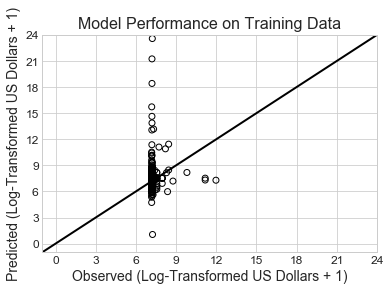

In [10]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, one_hidden_model)

In [11]:
def compute_MSE(predictors, observed_outcomes, model):
    
    # Computes the mean squared error of the model
    # predictors = the variables and values used in prediction
    # observed_outcomes = what the prediction would ideally yield
    # Returns a PyTorch Variable
    
    
    # Get the validation set predictions
    predictors.requires_grad = False
    predictions = model(predictors)
    
    # Get the validation set outcomes
    outcomes = observed_outcomes
    
    # Get the loss - (total) residual sum of squares
    total_SE = loss_fn(predictions, outcomes)
    
    # Average that to get mean square error
    mean_SE = total_SE / len(predictors)
    return(mean_SE)

In [12]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, one_hidden_model)
MSE

tensor(0.3224, grad_fn=<DivBackward0>)

<h3>1.4 Two hidden layer NN</h3>

In [13]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 5)
        self.fc2 = torch.nn.Linear(5, 3)
        self.fc3 = torch.nn.Linear(3, 1)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return(x)
    
# Make it
two_hidden_model = Net()

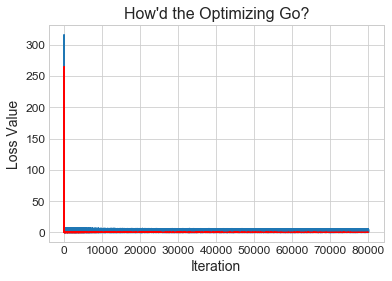

In [37]:
train_neural_net(two_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)

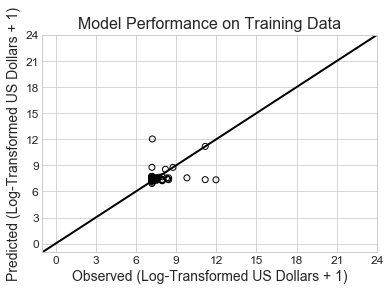

In [15]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, two_hidden_model)

In [16]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, two_hidden_model)
MSE

tensor(0.9148, grad_fn=<DivBackward0>)

<h3>1.5 Our own Deep Neural Net</h3>

In [30]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(7, 6)
        self.fc2 = torch.nn.Linear(6, 5)
        self.fc3 = torch.nn.Linear(5, 4)
        self.fc4 = torch.nn.Linear(4, 3)
        self.fc5 = torch.nn.Linear(3, 2)
        self.fc6 = torch.nn.Linear(2, 1)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.relu(self.fc4(x))
        x = torch.nn.functional.relu(self.fc5(x))
        x = self.fc6(x)
        return(x)
    
# Make it
multi_hidden_model = Net()

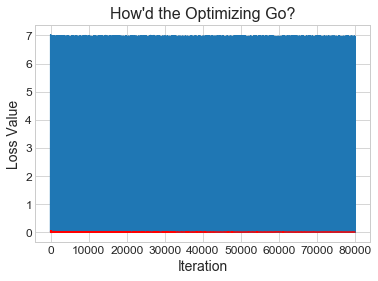

In [39]:
train_neural_net(multi_hidden_model, outcome_Tensor_train, predictors_Tensor_train,
                outcome_Tensor_test, predictors_Tensor_test)

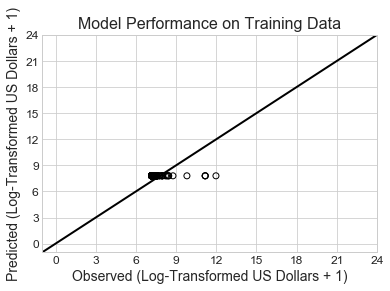

In [32]:
plot_train_perf(predictors_Tensor_train, outcome_Tensor_train, multi_hidden_model)

In [33]:
MSE = compute_MSE(predictors_Tensor_test, outcome_Tensor_test, multi_hidden_model)
MSE

tensor(0.0163, grad_fn=<DivBackward0>)

<h2>2. Thunderstorms in Texas with income</h2>

In [43]:
texas_income_data = pd.read_csv("MACHINE_LEARNING_DATA/county_year/texas_median_county_income_all.csv")
texas_income_data.info()
texas_income_data.values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3302 entries, 0 to 3301
Data columns (total 2 columns):
name        3302 non-null object
estimate    3301 non-null float64
dtypes: float64(1), object(1)
memory usage: 51.7+ KB


array([['ANDERSON CO.1990', 27752.0],
       ['ANDREWS CO.1990', 31106.0],
       ['ANGELINA CO.1990', 31157.0],
       ...,
       ['YOUNG CO.2019', 46351.0],
       ['ZAPATA CO.2019', 34550.0],
       ['ZAVALA CO.2019', 25988.0]], dtype=object)

In [93]:
# Add column to input features
# 1990, 2000, 2009 forward 
def parse_date(year):
    if int(year) < 95:
        return '1990'
    elif int(year) >= 95 or int(year) < 5:
        return '2000'
    elif int(year) >= 5 and int(year) < 9:
        return '2009'
    elif int(year) >= 9:
        return '20' + year
    
thunderstorm_predictors['MEAN_INCOME'] = 100
years = [date.split('/')[-1] for date in data['BEGIN_DATE']]
years = [parse_date(year) for year in years]
for i in range(len(thunderstorm_predictors)):
    keyword = data['CZ_NAME_STR'][i] + years[i]
    estimate = texas_income_data[texas_income_data['name'] == keyword].values[0][1]
    thunderstorm_predictors['MEAN_INCOME'][i] = estimate
thunderstorm_predictors

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,BEGIN_TIME,MAGNITUDE,DAMAGE_CROPS_NUM,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,MEAN_INCOME
0,1947,69.0,0,31.1344,-97.5247,31.1344,-97.5247,46590
1,1935,74.0,0,31.1344,-97.5247,31.1344,-97.5247,46590
2,2010,78.0,0,31.1344,-97.5247,31.1344,-97.5247,46590
3,251,52.0,10000,29.3691,-96.1527,29.3691,-96.1527,42428
4,1720,55.0,0,32.2455,-99.8125,32.2455,-99.8125,44914
5,2006,65.0,0,31.8246,-102.5298,31.8246,-102.5298,30413
6,1740,75.0,0,34.4604,-102.7135,34.4604,-102.7135,40801
7,1520,57.0,0,31.5182,-97.1790,31.5182,-97.1790,29629
8,2345,60.0,0,36.2464,-100.3498,36.2464,-100.3498,30356
9,2015,60.0,0,35.3831,-100.3498,35.3831,-100.3498,25592
